In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import os, shutil, pickle, shelve
from Bio import SeqIO
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model, Model
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.initializers import glorot_normal
import keras
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots

Using TensorFlow backend.


In [2]:
# sample data from:
data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"
output_folder_path = "../../../../temp/buffers/me_samples"

Uncomment the following code chunk to resample training and validation data

In [4]:
# !rm -r /home/ubuntu/data/temp/train
# !mkdir /home/ubuntu/data/temp/train
# !rm -r /home/ubuntu/data/temp/val
# !mkdir /home/ubuntu/data/temp/val

# # Sample training and validation data
# # Make sure that they don't have intersection.
# all_data_lst = np.array(os.listdir(data_dir))
# n = len(all_data_lst)
# train_files = all_data_lst[:500]
# num_val = 100
# val_indices = np.random.choice(np.arange(500, n), num_val, replace = False)
# val_files = all_data_lst[val_indices]

# train_dest = '/home/ubuntu/data/temp/train/'
# for file in train_files:
#     shutil.copy(os.path.join(data_dir, file),
#                           train_dest)
# print('copied training samples to {}'.format(train_dest))

# val_dest = '/home/ubuntu/data/temp/val/'
# for file in val_files:
#     shutil.copy(os.path.join(data_dir, file),
#                           val_dest)
# print('copied validation samples to {}'.format(val_dest))

# # Preprocess train and val data so that they are ready to be fed to models
# train_output_path = os.path.join(output_folder_path, 'train.data')
# val_output_path = os.path.join(output_folder_path, 'val.data')

# train_regions = one_hot_encoding(train_dest, train_output_path)
# val_regions = one_hot_encoding(val_dest, val_output_path)
# train_x, train_y = get_training_data(train_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'train_x.data', 
#                                    train_y_name = 'train_y.data')
# val_x, val_y = get_training_data(val_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'val_x.data', 
#                                    train_y_name = 'val_y.data')
# # Pad for motif detectors
# train_x, val_x = pad_for_detector(train_x, 15), pad_for_detector(val_x, 15)

In [ ]:
train_x = pickle.load(open('../../../../temp/buffers/me_samples/train_x.data', 'rb'))
train_y = pickle.load(open('../../../../temp/buffers/me_samples/train_y.data', 'rb'))
train_x, val_x = pad_for_detector(train_x, 15), pad_for_detector(val_x, 15)

In [6]:
# Define model:
class HybridModel:
    def __init__(self, K, M, input_length, rnn_size, config):
        # Extract configaration of the model:
        pool_size, strides = config['pool_size'], config['strides']
        dr1, dr2 = config['dr1'], config['dr2'] # dropout rates
        d = config['d'] # size of dense layers
        optimizer = config['opt']
        learning_rate = config['learning_rate']
        is_training = config['is_training'] # to control the dropout layers
        
        # Create the placeholders for the inputs:
        self.input = tf.placeholder(tf.float32, shape=[None, input_length, 4])
        self.targets = tf.placeholder(tf.int32, shape=[None, ])
        
        # Define layers for the model:
        self.K = K # number of filters
        
        self.conv = tf.layers.Conv1D(K, M,
                                     strides=1, padding='valid',
                                     use_bias=True, name='conv')
        self.lm_cell_fw = tf.nn.rnn_cell.LSTMCell(num_units = rnn_size, dtype = tf.float32, name='lm_cell_fw')
        self.lm_cell_bw = tf.nn.rnn_cell.LSTMCell(num_units = rnn_size, dtype = tf.float32, name='lm_cell_bw')
        
        # Feed in input
        #print(self.input.shape)
        self.activations = tf.nn.relu(self.conv(self.input))
        #print(self.activations.shape)
        outputs = tf.layers.max_pooling1d(self.activations, 
                                          pool_size=pool_size,
                                          strides=strides)
        outputs = tf.layers.dropout(outputs,
                                    rate=dr1,
                                    training=is_training)
        #print(outputs.shape)
        
        outputs, states = tf.nn.bidirectional_dynamic_rnn(self.lm_cell_fw,
                                                          self.lm_cell_bw,
                                                          outputs, dtype = tf.float32)
        outputs = tf.concat(outputs, axis=2)
        #print(outputs.shape)
        outputs = tf.layers.dropout(outputs,
                                    rate=dr2,
                                    training=is_training)
        
        outputs = tf.nn.relu(tf.layers.dense(outputs, d, name='dense1'))
        #print(outputs.shape)
        output_logits = tf.layers.dense(outputs, 1, name='dense2')
        #print(output_logits.shape)
        
        self.loss = tf.losses.sparse_softmax_cross_entropy(self.targets, output_logits)
        #print(self.loss.shape)
        self.global_step = tf.train.get_or_create_global_step()
        self.train_op = optimizer.minimize(self.loss)
        self.saver = tf.train.Saver()

In [7]:
tf.reset_default_graph() # Reset the computational graph before defining a new model.

optimizers = {'adam': tf.train.AdamOptimizer(learning_rate=1e-3),
              'rmsprop': tf.train.RMSPropOptimizer(learning_rate=1e-3)}
opt = optimizers['rmsprop']
model_config = {'pool_size': 5, 'strides': 5, 'dr1': 0.6, 'dr2': 0.7, 'd': 20, 
          'opt': opt, 'learning_rate': 1e-2, 'is_training': True}
model = HybridModel(K=30, M=15, input_length=1028, rnn_size=15, config=model_config)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling1d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [8]:
# Define training function:
def train(model, train_x, train_y, val_x, val_y, config, verbose=True, print_every=10):
    epochs, iteration, output_path = config['epochs'], config['iteration'], config['output_path']
    train_loss_record, val_loss_record = [], []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epochs):
            print("epoch {}".format(epoch))
            for iters in range(iteration):
                # Here is how you obtain a batch:
                batch_size = train_x.shape[0] // iteration
                #print(batch_size)
                train_indices = np.random.choice(np.arange(train_x.shape[0]), batch_size, replace=False)
                sub_train_x, sub_train_y = train_x[train_indices, :, :], train_y[train_indices]
                feed = {model.input: sub_train_x, model.targets: sub_train_y}
                model.is_training = True
                step, train_loss, _ = sess.run([model.global_step, model.loss, model.train_op], feed_dict=feed)
                if verbose:
                    if iters % print_every == 0:
                        print("    iteration {}, train_loss: {}".format(iters, train_loss))
            val_indices = np.random.choice(np.arange(val_x.shape[0]), 2400, replace = False)
            sub_val_x, sub_val_y = val_x[val_indices, :, :], val_y[val_indices]
            feed = {model.input: sub_val_x, model.targets: sub_val_y}
            model.is_training = False
            val_loss = sess.run([model.loss], feed_dict=feed)
            val_loss_record.append(val_loss)
            train_loss_record.append(train_loss)
            print("validation loss: {}".format(val_loss))
        # Here is how you save the model weights
        model.saver.save(sess, output_path)
    return train_loss_record, val_loss_record

In [9]:
# Save the model for later analysis
save_model_path = '/home/ubuntu/data/team_neural_network/code/models'
model_name = 'hybrid_net-tensorflow.h5'
output_path = os.path.join(save_model_path, model_name)
training_config = {'epochs': 35, 'iteration': 100, 'output_path': output_path}

train_loss_record, val_loss_record = train(model, train_x, train_y, val_x, val_y, training_config)

epoch 0
    iteration 0, train_loss: 5.384913444519043
    iteration 10, train_loss: 5.3469696044921875
    iteration 20, train_loss: 5.3420610427856445
    iteration 30, train_loss: 5.293630123138428
    iteration 40, train_loss: 5.216133117675781
    iteration 50, train_loss: 5.183137893676758
    iteration 60, train_loss: 5.069476127624512
    iteration 70, train_loss: 4.925942897796631
    iteration 80, train_loss: 4.655019283294678
    iteration 90, train_loss: 4.373633861541748
validation loss: [3.8718624]
epoch 1
    iteration 0, train_loss: 3.8972346782684326
    iteration 10, train_loss: 3.3315398693084717
    iteration 20, train_loss: 2.8374128341674805
    iteration 30, train_loss: 2.416781187057495
    iteration 40, train_loss: 2.0785772800445557
    iteration 50, train_loss: 1.8875325918197632
    iteration 60, train_loss: 1.6729018688201904
    iteration 70, train_loss: 1.489064335823059
    iteration 80, train_loss: 1.3816629648208618
    iteration 90, train_loss: 1.3112

    iteration 70, train_loss: 0.5537064671516418
    iteration 80, train_loss: 0.5736018419265747
    iteration 90, train_loss: 0.6402178406715393
validation loss: [0.77980113]
epoch 16
    iteration 0, train_loss: 0.6257760524749756
    iteration 10, train_loss: 0.6706918478012085
    iteration 20, train_loss: 0.6542856693267822
    iteration 30, train_loss: 0.5871003270149231
    iteration 40, train_loss: 0.5867918133735657
    iteration 50, train_loss: 0.6684929132461548
    iteration 60, train_loss: 0.6947860717773438
    iteration 70, train_loss: 0.5800827741622925
    iteration 80, train_loss: 0.598261296749115
    iteration 90, train_loss: 0.5985063910484314
validation loss: [0.8066593]
epoch 17
    iteration 0, train_loss: 0.6457403302192688
    iteration 10, train_loss: 0.587816596031189
    iteration 20, train_loss: 0.5977725982666016
    iteration 30, train_loss: 0.6719723343849182
    iteration 40, train_loss: 0.6201974153518677
    iteration 50, train_loss: 0.5890728235244

    iteration 30, train_loss: 0.5881920456886292
    iteration 40, train_loss: 0.5240142941474915
    iteration 50, train_loss: 0.5670867562294006
    iteration 60, train_loss: 0.5613515973091125
    iteration 70, train_loss: 0.6174558997154236
    iteration 80, train_loss: 0.49555256962776184
    iteration 90, train_loss: 0.5704793334007263
validation loss: [0.866627]
epoch 32
    iteration 0, train_loss: 0.5823479890823364
    iteration 10, train_loss: 0.573551595211029
    iteration 20, train_loss: 0.5214524269104004
    iteration 30, train_loss: 0.5281431674957275
    iteration 40, train_loss: 0.6403011679649353
    iteration 50, train_loss: 0.5447624325752258
    iteration 60, train_loss: 0.5400736927986145
    iteration 70, train_loss: 0.5236027240753174
    iteration 80, train_loss: 0.5556281208992004
    iteration 90, train_loss: 0.5692905187606812
validation loss: [0.80847055]
epoch 33
    iteration 0, train_loss: 0.5919811129570007
    iteration 10, train_loss: 0.542256295680

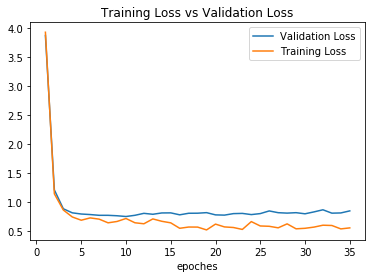

In [13]:
epochs = range(1, len(val_loss_record) + 1)

plt.plot(epochs, val_loss_record, '-', label='Validation Loss')
plt.plot(epochs, train_loss_record, '-', label='Training Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('epoches')
plt.legend()

## Subset sampling

In [11]:
input_folder_path = "../../../../temp/samples/"
output_folder_path = "../../../../temp/buffers/ss_samples"

# sample data from:
data_dir = "/home/ubuntu/group_volume/team_neural_network/data/input/3.24_species_only"

len(os.listdir(data_dir)) # total number of regions

3543

In [14]:
# !rm -r /home/ubuntu/data/temp/samples
# !mkdir /home/ubuntu/data/temp/samples

In [15]:
# all_data_lst = np.array(os.listdir(data_dir))
# num_samples = 209

# sampling(data_dir, input_folder_path, num_samples, seed = 189)

# output_file_path = os.path.join(output_folder_path, 'train.data')
# train_regions = one_hot_encoding(input_folder_path, output_file_path)

# data_x, data_y = get_training_data(train_regions, output_folder_path,
#                                    max_len = 1000, 
#                                    train_x_name = 'train_x.data', 
#                                    train_y_name = 'train_y.data')

# train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)

In [21]:
data_x = pickle.load(open('../../../../temp/buffers/train_x.data', 'rb'))
data_y = pickle.load(open('../../../../temp/buffers/train_y.data', 'rb'))

In [22]:
train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)

12000 (9600, 1000, 4) (9600,) (2400, 1000, 4) (2400,)


In [23]:
train_x, val_x = pad_for_detector(train_x, 15), pad_for_detector(val_x, 15)

In [24]:
# Save the model for later analysis
save_model_path = '/home/ubuntu/data/team_neural_network/code/models'
model_name = 'hybrid_net-tensorflow-2.h5'
output_path = os.path.join(save_model_path, model_name)
training_config = {'epochs': 35, 'iteration': 100, 'output_path': output_path}

train_loss_record, val_loss_record = train(model, train_x, train_y, val_x, val_y, training_config)

epoch 0
    iteration 0, train_loss: 5.400801181793213
    iteration 10, train_loss: 5.384999752044678
    iteration 20, train_loss: 5.350027561187744
    iteration 30, train_loss: 5.353002071380615
    iteration 40, train_loss: 5.269787311553955
    iteration 50, train_loss: 5.124022006988525
    iteration 60, train_loss: 5.06173849105835
    iteration 70, train_loss: 4.9452362060546875
    iteration 80, train_loss: 4.690897464752197
    iteration 90, train_loss: 4.239868640899658
validation loss: [3.8546667]
epoch 1
    iteration 0, train_loss: 3.8864567279815674
    iteration 10, train_loss: 3.368736982345581
    iteration 20, train_loss: 2.750802993774414
    iteration 30, train_loss: 2.4254209995269775
    iteration 40, train_loss: 2.101635694503784
    iteration 50, train_loss: 1.6022752523422241
    iteration 60, train_loss: 1.5020135641098022
    iteration 70, train_loss: 1.5331519842147827
    iteration 80, train_loss: 1.4036635160446167
    iteration 90, train_loss: 1.2134726

    iteration 70, train_loss: 0.5773077607154846
    iteration 80, train_loss: 0.6421653628349304
    iteration 90, train_loss: 0.6068955063819885
validation loss: [0.6381568]
epoch 16
    iteration 0, train_loss: 0.5747350454330444
    iteration 10, train_loss: 0.617926299571991
    iteration 20, train_loss: 0.6130749583244324
    iteration 30, train_loss: 0.5373334288597107
    iteration 40, train_loss: 0.5630791783332825
    iteration 50, train_loss: 0.6024407744407654
    iteration 60, train_loss: 0.5914209485054016
    iteration 70, train_loss: 0.631920337677002
    iteration 80, train_loss: 0.5883446931838989
    iteration 90, train_loss: 0.6240007281303406
validation loss: [0.6492068]
epoch 17
    iteration 0, train_loss: 0.6115298271179199
    iteration 10, train_loss: 0.592290461063385
    iteration 20, train_loss: 0.5560094714164734
    iteration 30, train_loss: 0.61726313829422
    iteration 40, train_loss: 0.6182331442832947
    iteration 50, train_loss: 0.6115777492523193


    iteration 30, train_loss: 0.5537970662117004
    iteration 40, train_loss: 0.5200377106666565
    iteration 50, train_loss: 0.5912787914276123
    iteration 60, train_loss: 0.5829278826713562
    iteration 70, train_loss: 0.5247385501861572
    iteration 80, train_loss: 0.5041388869285583
    iteration 90, train_loss: 0.5240468382835388
validation loss: [0.60263497]
epoch 32
    iteration 0, train_loss: 0.6192811131477356
    iteration 10, train_loss: 0.5141210556030273
    iteration 20, train_loss: 0.5038297176361084
    iteration 30, train_loss: 0.6479779481887817
    iteration 40, train_loss: 0.6874573826789856
    iteration 50, train_loss: 0.5809447169303894
    iteration 60, train_loss: 0.5053843855857849
    iteration 70, train_loss: 0.5780931711196899
    iteration 80, train_loss: 0.5233991742134094
    iteration 90, train_loss: 0.5976720452308655
validation loss: [0.5898661]
epoch 33
    iteration 0, train_loss: 0.5498242974281311
    iteration 10, train_loss: 0.64766329526

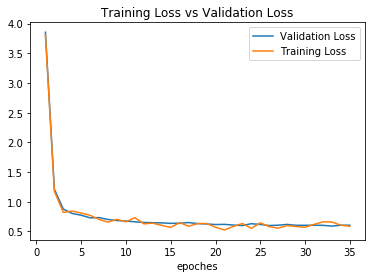

In [26]:
epochs = range(1, len(val_loss_record) + 1)

plt.plot(epochs, val_loss_record, '-', label='Validation Loss')
plt.plot(epochs, train_loss_record, '-', label='Training Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('epoches')
plt.legend()